In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyshtools as pysh
from pyshtools import SHGrid
import cartopy.crs as ccrs
import matplotlib
from matplotlib import cm
import xarray as xr
import pandas as pd
from netCDF4 import Dataset
import scipy as sp
from skimage.filters import gaussian
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

This is a notebook to plot and understand boundary netcdf files described in [Dapré & Irving 2025](https://doi.org/10.1029/2024JE008644) designed to be used with [AxiSEM3D](https://github.com/AxiSEMunity/AxiSEM3D).

The values in all the geometric netcdfs represent perturbations to the relevant boundary, and are given in terms of planetary radius (in metres). For example, in the basal topography files, this modifies the ice-ocean boundary such that a positive number is a reduction in ice thickness (because the boundary is pushed out to higher radius). In order to reproduce shell thickness maps, you therefore must start with a uniform 20km thickness (which is the ice thickness in the starting 1D seismic models), add the surface topography, and subtract the basal topography.

If you want the ability to alter spherical harmonic degrees of these shape models, I suggest asking the authors directly for those coefficients – they were very happy to provide me with them originally. These are [Hemingway & Mittal 2019](https://doi.org/10.1016/j.icarus.2019.03.011) and [Čadek et al. 2019](https://doi.org/10.1016/j.icarus.2018.10.003).

The appendices of [Tajeddine et al 2017](https://doi.org/10.1016/j.icarus.2017.04.019) are very useful in understanding the surface topographic model, and their spherical harmonic solutions are attached to that paper as supplementary files if you wish to reproduce them from scratch. The topography of Enceladus is dominated by the degree-2 shape, so if you plot the surface topography model it will look like a degree 2 map. If you exclusively plot degree >2 (which you will need their coefficient files for), the surface looks a lot more rugged – they have made plots that show this in their appendices.

## Begin by reading in and plotting each netcdf boundary model as an xarray

<xarray.Dataset>
Dimensions:    (nlat: 53, nlon: 105)
Dimensions without coordinates: nlat, nlon
Data variables:
    latitude   (nlat) float64 ...
    longitude  (nlon) float64 ...
    iob        (nlat, nlon) float64 ...


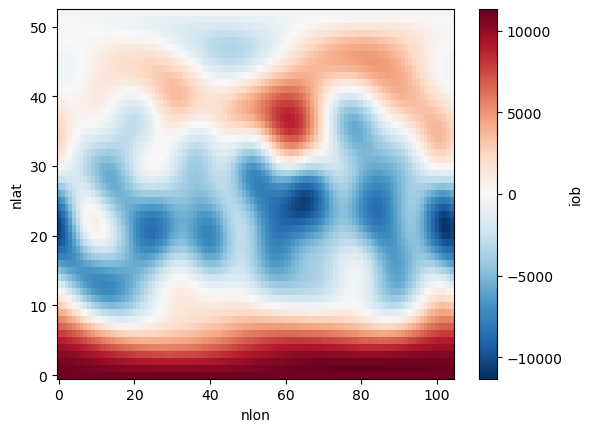

In [2]:
read_iobh = xr.open_dataset('Enceladus_data/model_files/Hemingway_basal_topography.nc')
print(read_iobh)
H_grid = read_iobh['iob']
read_iobh['iob'].plot()
read_iobh.close()

<xarray.Dataset>
Dimensions:    (nlat: 53, nlon: 105)
Dimensions without coordinates: nlat, nlon
Data variables:
    latitude   (nlat) float64 ...
    longitude  (nlon) float64 ...
    iob        (nlat, nlon) float64 ...


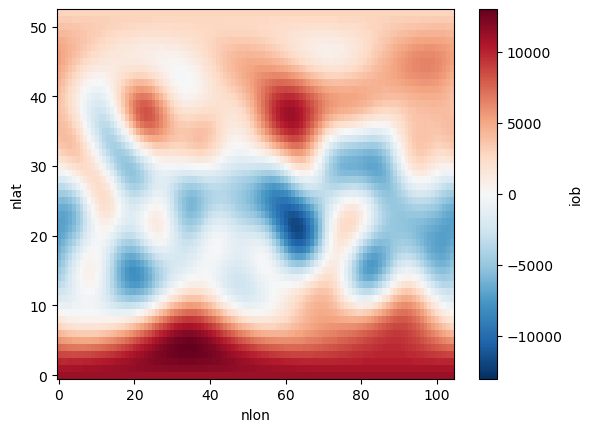

In [3]:
read_iobc = xr.open_dataset('Enceladus_data/model_files/Cadek_basal_topography.nc')
print(read_iobc)
C_grid = read_iobc['iob']
read_iobc['iob'].plot()
read_iobc.close()

<xarray.Dataset>
Dimensions:    (nlat: 53, nlon: 105)
Dimensions without coordinates: nlat, nlon
Data variables:
    latitude   (nlat) float64 ...
    longitude  (nlon) float64 ...
    surface    (nlat, nlon) float64 ...


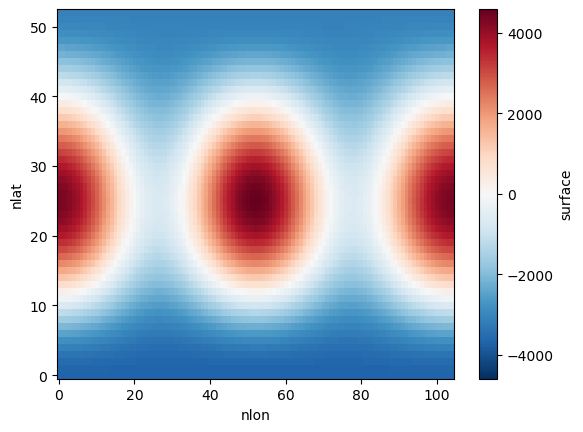

In [4]:
read_surf = xr.open_dataset('Enceladus_data/model_files/surface_topography.nc')
print(read_surf)
T_surf_grid = read_surf['surface']
lat_list = read_surf['latitude']
lon_list = read_surf['longitude']
read_surf['surface'].plot()
read_surf.close()

### 2D model versions of the above also exist (see Dapré & Irving 2025)

<xarray.Dataset>
Dimensions:    (nlat: 35, nlon: 69)
Dimensions without coordinates: nlat, nlon
Data variables:
    latitude   (nlat) float64 ...
    longitude  (nlon) float64 ...
    surface    (nlat, nlon) float64 ...


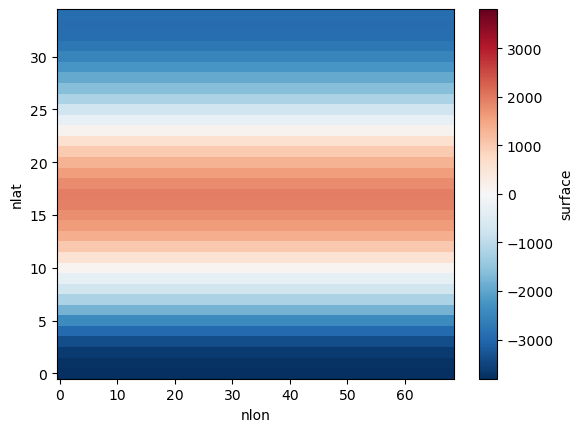

In [7]:
read_2Dsurf = xr.open_dataset('Enceladus_data/model_files/2D_surface_topography.nc')
print(read_2Dsurf)
T_surf_grid2D = read_2Dsurf['surface']
lat_list2D = read_2Dsurf['latitude']
lon_list2D = read_2Dsurf['longitude']
read_2Dsurf['surface'].plot()
read_2Dsurf.close()

<xarray.Dataset>
Dimensions:    (nlat: 35, nlon: 69)
Dimensions without coordinates: nlat, nlon
Data variables:
    latitude   (nlat) float64 ...
    longitude  (nlon) float64 ...
    iob        (nlat, nlon) float64 ...


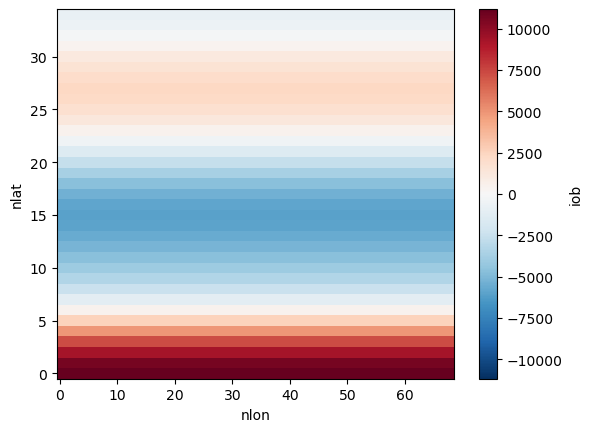

In [8]:
read_2Diobh = xr.open_dataset('Enceladus_data/model_files/2D_Hemingway_basal_topography.nc')
print(read_2Diobh)
T_iobh_grid2D = read_2Diobh['iob']
lat_list2D = read_2Diobh['latitude']
lon_list2D = read_2Diobh['longitude']
read_2Diobh['iob'].plot()
read_2Diobh.close()

In [10]:
# generate 1D thickness array of the same size as everything else - constant 20km ice shell
thickness_1D = np.full(np.shape(np.array(lat_list)),20)

C:\Users\mercu\AppData\Local\Temp\ipykernel_8852\3493285852.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


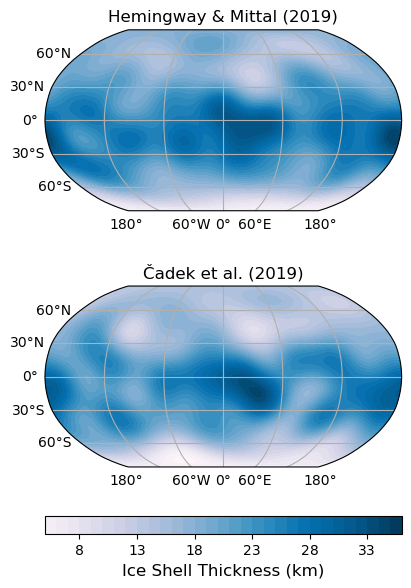

In [6]:
# ice thickness figure

# choose global limits on the colorbar by specifying min and max thickness
vmin = 3
vmax= 36

# mesh lon and lat coords for plotting
lon_grid, lat_grid = np.meshgrid(lon_list,lat_list)

fig, axs = plt.subplots(2,1, layout='constrained',subplot_kw={'projection': ccrs.Robinson()},figsize=(4,6))

# Hemingway ice thickness
ax1 = axs[0]
surf1 = ax1.contourf(lon_grid,lat_grid,(20000+T_surf_grid-H_grid)/1000,cmap=cm.PuBu,levels=vmax-vmin,transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax)
ax1.set_global()
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,zorder=1)
gl.right_labels=False
gl.top_labels=False

# Cadek ice thickness
ax2 = axs[1]
surf2 = ax2.contourf(lon_grid,lat_grid,(20000+T_surf_grid-C_grid)/1000,cmap=cm.PuBu,levels=vmax-vmin,transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax)
ax2.set_global()
gl = ax2.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,zorder=1)
gl.right_labels=False
gl.top_labels=False

# add shared colorbar
cbar = fig.colorbar(surf1,ax=[ax1,ax2],ticks=range(vmin,vmax,5), location = 'bottom',orientation='horizontal')
cbar.set_label('Ice Shell Thickness (km)',size=12)

ax1.set_title('Hemingway & Mittal (2019)')
ax2.set_title('Čadek et al. (2019)')
fig.show()

C:\Users\mercu\AppData\Local\Temp\ipykernel_8852\3099004296.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


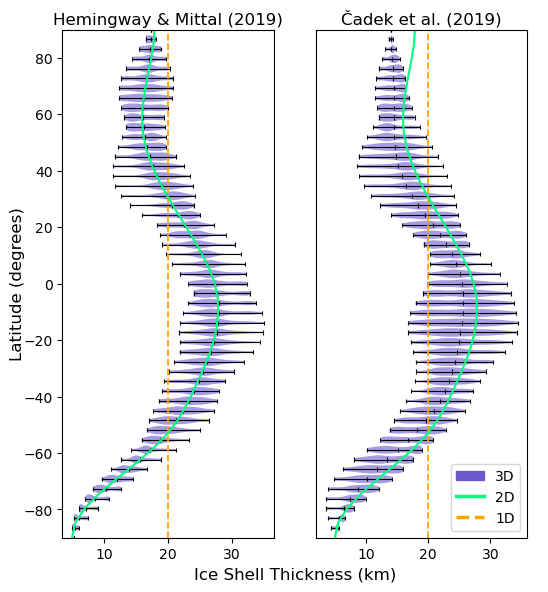

In [59]:
# model dimensionality comparison figure

fig, axs = plt.subplots(nrows=1,ncols=2)

# violin plot of Hemingway thicknesses per latitude
ax1 = axs[0].violinplot(((20000+T_surf_grid-H_grid)/1000).T,np.array(lat_list),widths=3,vert=False,showmeans=True)
axs[0].set_xlabel("Hemingway & Mittal (2019)",fontsize=12)
axs[0].xaxis.set_label_position('top')
axs[0].set_ylim(-90,90)

#violin plot of Čadek thicknesses per latitude
ax2 = axs[1].violinplot(((20000+T_surf_grid-C_grid)/1000).T,np.array(lat_list),widths=3,vert=False,showmeans=True)
axs[1].set_xlabel("Čadek et al. (2019)",fontsize=12)
axs[1].xaxis.set_label_position('top')
axs[1].set_ylim(-90,90)

#format both violin plots - violin color ('bodies'), and line format ('c-everything else')
for pc in ax1['bodies']:
    pc.set_facecolor('slateblue')
    pc.set_alpha(0.6)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = ax1[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(0.8)
    
for pc in ax2['bodies']:
    pc.set_facecolor('slateblue')
    pc.set_alpha(0.6)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = ax2[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(0.8)

# Add 1D and 2D thickness models to both plots
for ax in axs[0:]:
    ax.plot(thickness_1D,np.array(lat_list),'--',linewidth=1.3,color="orange")
    ax.plot(np.array(20000-T_iobh_grid2D+T_surf_grid2D)[:,0]/1000,np.flip(np.array(lat_list2D)),color="springgreen")

# hide y-ticks on second axes
axs[1].axes.get_yaxis().set_visible(False)

# add global axes for labelling
violins = fig.add_subplot(1,2,(1,2), frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Ice Shell Thickness (km)",fontsize=12)
plt.ylabel("Latitude (degrees)",fontsize=12)

# create custom legend
violin_data = mpatches.Patch(color='slateblue', label='3D')
twoD_data =Line2D([0],[0],lw=2.5,color='springgreen',label='2D')
oneD_data = Line2D([0],[0],lw=2.5,linestyle='--',color='orange',label='1D')
plt.legend(handles=[violin_data,twoD_data,oneD_data],loc="lower right")

fig.set_size_inches(6,6.6)

fig.show()